# 3D Resnet

In [1]:
import logging
logging.basicConfig(level=logging.INFO)

logger = logging.getLogger(__name__)

In [2]:
from mlflow.tracking import MlflowClient

MLFLOW_TRACKING_SERVER_URI = "http://localhost:20000"

mlflow_client = MlflowClient(MLFLOW_TRACKING_SERVER_URI)

In [3]:
from mlflow.entities import Experiment

import mlflow

mlflow.set_tracking_uri(MLFLOW_TRACKING_SERVER_URI)

experiment: Experiment = mlflow.set_experiment(experiment_name="3D ResNet")

2023/09/04 00:55:20 INFO mlflow.tracking.fluent: Experiment with name '3D ResNet' does not exist. Creating a new experiment.


In [4]:
run = mlflow_client.create_run(
    experiment_id=experiment.experiment_id,
)

In [5]:
from recognizer.utils.constants import ROOT_DIR, TARGET_TO_ENCODING
from recognizer.utils.utils import get_metadata_from_filename

DATASET_DIR_POSTA = ROOT_DIR / "data" / "all-20percent"

## Load Data

In [6]:
import os

import pandas as pd

targets = []
subjects = []
repetitions = []
files = []

for file in os.listdir(DATASET_DIR_POSTA):

    target, subject, repetition = get_metadata_from_filename(file)

    targets.append(target)
    subjects.append(subject)
    repetitions.append(repetition)
    files.append(str((DATASET_DIR_POSTA / file).resolve()))


metadata = pd.DataFrame(
    data={
        "target": targets,
        "subject": subjects,
        "repetition": repetitions,
        "file": files,
    }
)

metadata["target_encoding"] = metadata["target"].map(TARGET_TO_ENCODING)

metadata.head()

,target,subject,repetition,file,target_encoding
0,001,001,001,C:\Users\facun\Desktop\DEV\ecd-trabajo-final\d...,0
1,001,001,002,C:\Users\facun\Desktop\DEV\ecd-trabajo-final\d...,0
2,001,001,003,C:\Users\facun\Desktop\DEV\ecd-trabajo-final\d...,0
3,001,001,004,C:\Users\facun\Desktop\DEV\ecd-trabajo-final\d...,0
4,001,001,005,C:\Users\facun\Desktop\DEV\ecd-trabajo-final\d...,0


### Train/Test split

In [7]:
import numpy as np

size = 1
replace = False
fn = lambda obj: obj.loc[np.random.choice(obj.index, size, replace),:]

testing_set = metadata.groupby(["target", "subject"], as_index=False).apply(fn)

testing_set.index = testing_set.index.droplevel(0)

training_set = metadata.loc[~metadata.index.isin(testing_set.index), :]

### Pre-processing functions

In [8]:
def transform(x):
    """Permutes the element to match the format expected by PyTorch: (C<channels>, T<frames>, H<height>, W<width>)"""
    # Transpose video from (T<frames>, H<height>, W<width>, C<channels>) to (C<channels>, T<frames>, H<height>, W<width>)
    return x.permute(3, 0, 1, 2).float()


### Datasets

In [9]:
BATCH_SIZE = 24
NUM_CLASSES = 64
NUM_FRAMES = 16
EPOCHS = 30
LR = 0.001

mlflow_client.log_param(run_id=run.info.run_id, key="BATCH_SIZE", value=BATCH_SIZE)
mlflow_client.log_param(run_id=run.info.run_id, key="NUM_CLASSES", value=NUM_CLASSES)
mlflow_client.log_param(run_id=run.info.run_id, key="EPOCHS", value=EPOCHS)
mlflow_client.log_param(run_id=run.info.run_id, key="NUM_FRAMES", value=NUM_FRAMES)
mlflow_client.log_param(run_id=run.info.run_id, key="LR", value=LR)

0.001

In [10]:
from recognizer.dataset import SampledVideoDataset

training_dataset = SampledVideoDataset(
    video_filenames=training_set["file"].values,
    labels=training_set["target_encoding"].values,
    num_frames=NUM_FRAMES,
    transform=transform,
)

testing_dataset = SampledVideoDataset(
    video_filenames=testing_set["file"].values,
    labels=testing_set["target_encoding"].values,
    num_frames=NUM_FRAMES,
    transform=transform,
)

print(f"Training/testing set: ({len(training_dataset)}, {len(testing_dataset)})")

Training/testing set: (2560, 640)


### Data Loaders

In [11]:
import torch 

from torch import nn

from recognizer.models.resnet_3d import Simple3DResNet

# Las imágenes del video son de 192 x 108
# Hay 8 frames por video

# Es decir que cada elemento input será de 3x8x108x192 (C<channels> * T<frames> * H<height> * W<width>) 

model = Simple3DResNet(
    num_classes=NUM_CLASSES,
)

train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle = True)

test_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=BATCH_SIZE, shuffle = False)

loss_function = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
model.to(device)

device

'cuda'

In [12]:
p = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Params: {p}")

Params: 234576


In [18]:
for n, p in model.named_parameters():
    print(f"Param: {n} | Shape: {p.shape}")

Param: conv1.weight | Shape: torch.Size([16, 3, 5, 5, 5])
Param: bn1.weight | Shape: torch.Size([16])
Param: bn1.bias | Shape: torch.Size([16])
Param: layer1.conv1.weight | Shape: torch.Size([16, 16, 3, 3, 3])
Param: layer1.bn1.weight | Shape: torch.Size([16])
Param: layer1.bn1.bias | Shape: torch.Size([16])
Param: layer1.conv2.weight | Shape: torch.Size([16, 16, 3, 3, 3])
Param: layer1.bn2.weight | Shape: torch.Size([16])
Param: layer1.bn2.bias | Shape: torch.Size([16])
Param: layer2.conv1.weight | Shape: torch.Size([32, 16, 3, 3, 3])
Param: layer2.bn1.weight | Shape: torch.Size([32])
Param: layer2.bn1.bias | Shape: torch.Size([32])
Param: layer2.conv2.weight | Shape: torch.Size([32, 32, 3, 3, 3])
Param: layer2.bn2.weight | Shape: torch.Size([32])
Param: layer2.bn2.bias | Shape: torch.Size([32])
Param: layer2.downsample.0.weight | Shape: torch.Size([32, 16, 1, 1, 1])
Param: layer2.downsample.1.weight | Shape: torch.Size([32])
Param: layer2.downsample.1.bias | Shape: torch.Size([32])
P

## Training

In [19]:
import subprocess

CMD = '''
on run argv
  display notification (item 2 of argv) with title (item 1 of argv) sound name "Glass"
end run
'''

def notify(title, text):
    subprocess.call(['osascript', '-e', CMD, title, text])

In [20]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)

cm = None

metrics = {
    "training_loss": [],
    "testing_loss": [],
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1": []
}

In [21]:
print(
f"""
Beginning model training with parameters:
- Epochs: {EPOCHS}
- Batch Size: {BATCH_SIZE}
"""
)

for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1} - Training")

    model.train()

    running_training_loss = 0.0

    for _, data in enumerate(train_loader):

        batch, labels = data[0].to(device), data[1].to(device)

        logits = model(batch)

        loss = loss_function(logits, labels)

        running_training_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    average_training_loss = running_training_loss / len(train_loader)
    metrics["training_loss"].append(round(average_training_loss, 2))

    print(f"Epoch {epoch + 1} - AVG Training Loss: {average_training_loss:.2f}")

    # Evaluation
    print(f"Epoch {epoch + 1} - Evaluation")

    model.eval()

    all_preds = []
    all_targets = []

    running_testing_loss = 0.0

    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)

            logits = model(inputs)

            _, preds = torch.max(logits, 1)

            all_preds.extend(preds.detach().cpu())
            all_targets.extend(labels.detach().cpu())

            loss = loss_function(logits, labels)
            running_testing_loss += loss.item()

    average_testing_loss = running_testing_loss / len(test_loader)
    metrics["testing_loss"].append(round(average_testing_loss, 2))

    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

    metrics["accuracy"].append(accuracy_score(all_targets, all_preds))
    metrics["precision"].append(precision_score(all_targets, all_preds, average="macro"))
    metrics["recall"].append(recall_score(all_targets, all_preds, average="macro"))
    metrics["f1"].append(f1_score(all_targets, all_preds, average="macro"))

    for metric in metrics.keys():
        mlflow_client.log_metric(
            run_id=run.info.run_id,
            key=metric,
            value=metrics[metric][epoch],
            step=epoch,
        )

    if epoch == EPOCHS - 1:
        cm = confusion_matrix(all_targets, all_preds)

    print(f"""
Epoch {epoch}:
    - Accuracy  : {metrics['accuracy'][-1]}
    - Precision : {metrics['precision'][-1]}
    - Recall    : {metrics['recall'][-1]}
    - F1        : {metrics['f1'][-1]}
    """)


Beginning model training with parameters:
- Epochs: 30
- Batch Size: 24

Epoch 1 - Training
Epoch 1 - AVG Training Loss: 3.82
Epoch 1 - Evaluation


c:\Users\facun\AppData\Local\pypoetry\Cache\virtualenvs\recognizer-U-rlUTHu-py3.10\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch 0:
    - Accuracy  : 0.01875
    - Precision : 0.003515625
    - Recall    : 0.01875
    - F1        : 0.0038871951219512204
    
Epoch 2 - Training
Epoch 2 - AVG Training Loss: 3.58
Epoch 2 - Evaluation


c:\Users\facun\AppData\Local\pypoetry\Cache\virtualenvs\recognizer-U-rlUTHu-py3.10\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch 1:
    - Accuracy  : 0.028125
    - Precision : 0.008863831615120275
    - Recall    : 0.028125
    - F1        : 0.004602667297979798
    
Epoch 3 - Training
Epoch 3 - AVG Training Loss: 3.52
Epoch 3 - Evaluation


c:\Users\facun\AppData\Local\pypoetry\Cache\virtualenvs\recognizer-U-rlUTHu-py3.10\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch 2:
    - Accuracy  : 0.0421875
    - Precision : 0.013812546108647114
    - Recall    : 0.0421875
    - F1        : 0.01155699811701661
    
Epoch 4 - Training
Epoch 4 - AVG Training Loss: 3.49
Epoch 4 - Evaluation


c:\Users\facun\AppData\Local\pypoetry\Cache\virtualenvs\recognizer-U-rlUTHu-py3.10\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch 3:
    - Accuracy  : 0.0328125
    - Precision : 0.003975487253477347
    - Recall    : 0.0328125
    - F1        : 0.0066137961246850955
    
Epoch 5 - Training
Epoch 5 - AVG Training Loss: 3.45
Epoch 5 - Evaluation


c:\Users\facun\AppData\Local\pypoetry\Cache\virtualenvs\recognizer-U-rlUTHu-py3.10\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch 4:
    - Accuracy  : 0.0390625
    - Precision : 0.006166782303980767
    - Recall    : 0.0390625
    - F1        : 0.008757790889980133
    
Epoch 6 - Training
Epoch 6 - AVG Training Loss: 3.43
Epoch 6 - Evaluation


c:\Users\facun\AppData\Local\pypoetry\Cache\virtualenvs\recognizer-U-rlUTHu-py3.10\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch 5:
    - Accuracy  : 0.0296875
    - Precision : 0.0009582310367756124
    - Recall    : 0.0296875
    - F1        : 0.0018560642435300329
    
Epoch 7 - Training
Epoch 7 - AVG Training Loss: 3.38
Epoch 7 - Evaluation


c:\Users\facun\AppData\Local\pypoetry\Cache\virtualenvs\recognizer-U-rlUTHu-py3.10\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch 6:
    - Accuracy  : 0.03125
    - Precision : 0.0010584362662602272
    - Recall    : 0.03125
    - F1        : 0.0020425038869467905
    
Epoch 8 - Training
Epoch 8 - AVG Training Loss: 3.29
Epoch 8 - Evaluation


c:\Users\facun\AppData\Local\pypoetry\Cache\virtualenvs\recognizer-U-rlUTHu-py3.10\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch 7:
    - Accuracy  : 0.0609375
    - Precision : 0.016563573886783353
    - Recall    : 0.060937500000000006
    - F1        : 0.016782584053200295
    
Epoch 9 - Training
Epoch 9 - AVG Training Loss: 3.14
Epoch 9 - Evaluation


c:\Users\facun\AppData\Local\pypoetry\Cache\virtualenvs\recognizer-U-rlUTHu-py3.10\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch 8:
    - Accuracy  : 0.0296875
    - Precision : 0.0010211074561403508
    - Recall    : 0.0296875
    - F1        : 0.001971153846153846
    
Epoch 10 - Training
Epoch 10 - AVG Training Loss: 2.97
Epoch 10 - Evaluation


c:\Users\facun\AppData\Local\pypoetry\Cache\virtualenvs\recognizer-U-rlUTHu-py3.10\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch 9:
    - Accuracy  : 0.0453125
    - Precision : 0.003698758192625272
    - Recall    : 0.045312500000000006
    - F1        : 0.006813816614603628
    
Epoch 11 - Training
Epoch 11 - AVG Training Loss: 2.81
Epoch 11 - Evaluation


c:\Users\facun\AppData\Local\pypoetry\Cache\virtualenvs\recognizer-U-rlUTHu-py3.10\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch 10:
    - Accuracy  : 0.190625
    - Precision : 0.18447466103193852
    - Recall    : 0.19062500000000002
    - F1        : 0.1406536010555881
    
Epoch 12 - Training
Epoch 12 - AVG Training Loss: 2.65
Epoch 12 - Evaluation


c:\Users\facun\AppData\Local\pypoetry\Cache\virtualenvs\recognizer-U-rlUTHu-py3.10\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch 11:
    - Accuracy  : 0.2296875
    - Precision : 0.21240806103044038
    - Recall    : 0.2296875
    - F1        : 0.17066882743078723
    
Epoch 13 - Training
Epoch 13 - AVG Training Loss: 2.49
Epoch 13 - Evaluation


c:\Users\facun\AppData\Local\pypoetry\Cache\virtualenvs\recognizer-U-rlUTHu-py3.10\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch 12:
    - Accuracy  : 0.071875
    - Precision : 0.0401964864154607
    - Recall    : 0.071875
    - F1        : 0.02569046495112058
    
Epoch 14 - Training
Epoch 14 - AVG Training Loss: 2.30
Epoch 14 - Evaluation


c:\Users\facun\AppData\Local\pypoetry\Cache\virtualenvs\recognizer-U-rlUTHu-py3.10\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch 13:
    - Accuracy  : 0.175
    - Precision : 0.20017624170394654
    - Recall    : 0.17500000000000002
    - F1        : 0.13425225146840103
    
Epoch 15 - Training
Epoch 15 - AVG Training Loss: 2.11
Epoch 15 - Evaluation


c:\Users\facun\AppData\Local\pypoetry\Cache\virtualenvs\recognizer-U-rlUTHu-py3.10\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch 14:
    - Accuracy  : 0.2203125
    - Precision : 0.25657327319793477
    - Recall    : 0.22031249999999997
    - F1        : 0.172453920499827
    
Epoch 16 - Training
Epoch 16 - AVG Training Loss: 1.95
Epoch 16 - Evaluation


c:\Users\facun\AppData\Local\pypoetry\Cache\virtualenvs\recognizer-U-rlUTHu-py3.10\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch 15:
    - Accuracy  : 0.403125
    - Precision : 0.46147062158939406
    - Recall    : 0.403125
    - F1        : 0.3603521868345978
    
Epoch 17 - Training
Epoch 17 - AVG Training Loss: 1.76
Epoch 17 - Evaluation


c:\Users\facun\AppData\Local\pypoetry\Cache\virtualenvs\recognizer-U-rlUTHu-py3.10\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch 16:
    - Accuracy  : 0.415625
    - Precision : 0.4683284713984063
    - Recall    : 0.415625
    - F1        : 0.37609514394499777
    
Epoch 18 - Training
Epoch 18 - AVG Training Loss: 1.64
Epoch 18 - Evaluation


c:\Users\facun\AppData\Local\pypoetry\Cache\virtualenvs\recognizer-U-rlUTHu-py3.10\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch 17:
    - Accuracy  : 0.5484375
    - Precision : 0.6044420528356411
    - Recall    : 0.5484375
    - F1        : 0.5298789981140754
    
Epoch 19 - Training
Epoch 19 - AVG Training Loss: 1.51
Epoch 19 - Evaluation


c:\Users\facun\AppData\Local\pypoetry\Cache\virtualenvs\recognizer-U-rlUTHu-py3.10\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch 18:
    - Accuracy  : 0.5390625
    - Precision : 0.6065656069961937
    - Recall    : 0.5390625
    - F1        : 0.5055499487927422
    
Epoch 20 - Training
Epoch 20 - AVG Training Loss: 1.39
Epoch 20 - Evaluation


c:\Users\facun\AppData\Local\pypoetry\Cache\virtualenvs\recognizer-U-rlUTHu-py3.10\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch 19:
    - Accuracy  : 0.2484375
    - Precision : 0.31545129563090385
    - Recall    : 0.24843750000000003
    - F1        : 0.20041690626858844
    
Epoch 21 - Training
Epoch 21 - AVG Training Loss: 1.29
Epoch 21 - Evaluation


c:\Users\facun\AppData\Local\pypoetry\Cache\virtualenvs\recognizer-U-rlUTHu-py3.10\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch 20:
    - Accuracy  : 0.26875
    - Precision : 0.30793471364023633
    - Recall    : 0.26875000000000004
    - F1        : 0.23586154232388454
    
Epoch 22 - Training
Epoch 22 - AVG Training Loss: 1.21
Epoch 22 - Evaluation


c:\Users\facun\AppData\Local\pypoetry\Cache\virtualenvs\recognizer-U-rlUTHu-py3.10\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch 21:
    - Accuracy  : 0.4859375
    - Precision : 0.5988131581119386
    - Recall    : 0.4859375
    - F1        : 0.47090122653804944
    
Epoch 23 - Training
Epoch 23 - AVG Training Loss: 1.11
Epoch 23 - Evaluation


c:\Users\facun\AppData\Local\pypoetry\Cache\virtualenvs\recognizer-U-rlUTHu-py3.10\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch 22:
    - Accuracy  : 0.65625
    - Precision : 0.7301076810274041
    - Recall    : 0.65625
    - F1        : 0.647413469632244
    
Epoch 24 - Training
Epoch 24 - AVG Training Loss: 1.04
Epoch 24 - Evaluation


c:\Users\facun\AppData\Local\pypoetry\Cache\virtualenvs\recognizer-U-rlUTHu-py3.10\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch 23:
    - Accuracy  : 0.21875
    - Precision : 0.24699313528587424
    - Recall    : 0.21875
    - F1        : 0.1769340968619929
    
Epoch 25 - Training
Epoch 25 - AVG Training Loss: 0.97
Epoch 25 - Evaluation


c:\Users\facun\AppData\Local\pypoetry\Cache\virtualenvs\recognizer-U-rlUTHu-py3.10\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch 24:
    - Accuracy  : 0.2734375
    - Precision : 0.3141987404120503
    - Recall    : 0.2734375
    - F1        : 0.22903709062522726
    
Epoch 26 - Training
Epoch 26 - AVG Training Loss: 0.90
Epoch 26 - Evaluation


c:\Users\facun\AppData\Local\pypoetry\Cache\virtualenvs\recognizer-U-rlUTHu-py3.10\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch 25:
    - Accuracy  : 0.4546875
    - Precision : 0.49066426643957073
    - Recall    : 0.4546875
    - F1        : 0.4018005948960005
    
Epoch 27 - Training
Epoch 27 - AVG Training Loss: 0.83
Epoch 27 - Evaluation


c:\Users\facun\AppData\Local\pypoetry\Cache\virtualenvs\recognizer-U-rlUTHu-py3.10\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch 26:
    - Accuracy  : 0.4734375
    - Precision : 0.5560447570182527
    - Recall    : 0.47343749999999996
    - F1        : 0.453268015667452
    
Epoch 28 - Training
Epoch 28 - AVG Training Loss: 0.78
Epoch 28 - Evaluation


c:\Users\facun\AppData\Local\pypoetry\Cache\virtualenvs\recognizer-U-rlUTHu-py3.10\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch 27:
    - Accuracy  : 0.578125
    - Precision : 0.6181138096718748
    - Recall    : 0.578125
    - F1        : 0.5354228101990361
    
Epoch 29 - Training
Epoch 29 - AVG Training Loss: 0.73
Epoch 29 - Evaluation


c:\Users\facun\AppData\Local\pypoetry\Cache\virtualenvs\recognizer-U-rlUTHu-py3.10\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch 28:
    - Accuracy  : 0.653125
    - Precision : 0.7274820208038529
    - Recall    : 0.653125
    - F1        : 0.6298066466673538
    
Epoch 30 - Training
Epoch 30 - AVG Training Loss: 0.69
Epoch 30 - Evaluation

Epoch 29:
    - Accuracy  : 0.3546875
    - Precision : 0.4258801481142672
    - Recall    : 0.35468750000000004
    - F1        : 0.31570820244525033
    


c:\Users\facun\AppData\Local\pypoetry\Cache\virtualenvs\recognizer-U-rlUTHu-py3.10\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Evaluation

### Confusion Matrix

In [22]:
cm = confusion_matrix(all_targets, all_preds)

<AxesSubplot: >

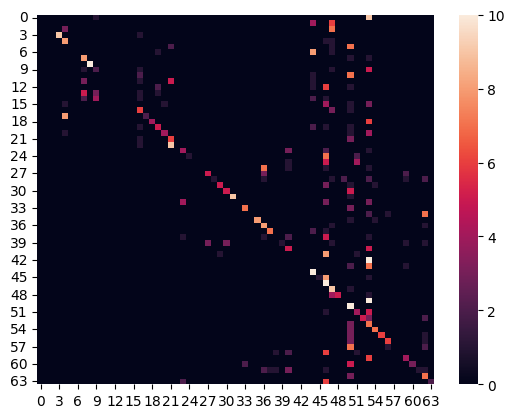

In [23]:
import seaborn as sns

sns.heatmap(data=cm)

### Accuracy/Recall/Precision

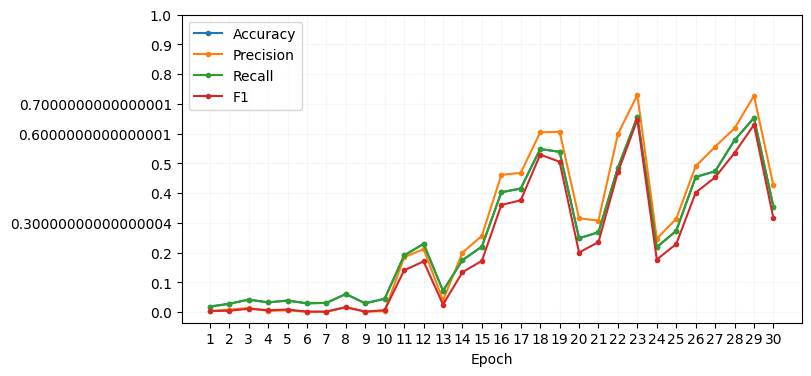

In [24]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.plot(metrics["accuracy"], label="Accuracy", marker=".")
ax.plot(metrics["precision"], label="Precision", marker=".")
ax.plot(metrics["recall"], label="Recall", marker=".")
ax.plot(metrics["f1"], label="F1", marker=".")

ax.set_xticks(range(0, epoch+1))
ax.set_xticklabels(range(1, epoch+2))
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_yticklabels(np.arange(0, 1.1, 0.1))
ax.set_xlabel("Epoch")
ax.legend()
ax.grid(alpha=0.1)
plt.show()

### Loss

In [25]:
print(metrics["testing_loss"])

[4.26, 3.99, 3.68, 3.89, 3.72, 7.83, 15.01, 3.61, 11.15, 6.08, 2.84, 2.69, 6.72, 3.75, 2.74, 2.03, 2.05, 1.7, 1.67, 3.8, 2.69, 1.56, 1.22, 3.43, 3.36, 2.01, 1.65, 1.44, 1.09, 2.37]


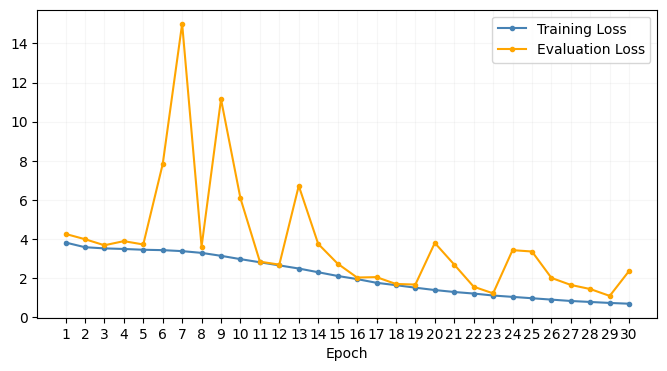

In [26]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.plot(metrics["training_loss"], label="Training Loss", marker=".", color="steelblue")
ax.plot(metrics["testing_loss"], label="Evaluation Loss", marker=".", color="orange")

ax.set_xticks(range(0, epoch+1))
ax.set_xticklabels(range(1, epoch+2))
ax.set_xlabel("Epoch")
ax.legend()
ax.grid(alpha=0.1)
plt.show()

## Save model

In [27]:
from recognizer.utils.constants import ROOT_DIR

MODELS_DIR = ROOT_DIR / "models"

MODEL_PATH = MODELS_DIR / "molchanov_3d_01_mlflow.pth"

with open(MODEL_PATH, "w") as f:
        f.write("")

torch.save(model, f=MODEL_PATH)

In [28]:
mlflow_client.log_artifact(
    run_id=run.info.run_id,
    local_path=str(MODELS_DIR / "molchanov_3d_01_mlflow.pth"),
    artifact_path="molchanov_3d_01_mlflow.pth",
)

NoCredentialsError: Unable to locate credentials

: 